![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from French to English.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](http://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a single vector, and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

# The Sequence to Sequence model

A [Sequence to Sequence network](http://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![](https://i.imgur.com/tVtHhNp.png)

When using a single RNN, there is a one-to-one relationship between inputs and outputs. We would quickly run into problems with different sequence orders and lengths that are common during translation. Consider the simple sentence "Je ne suis pas le chat noir" &rarr; "I am not the black cat". Many of the words have a pretty direct translation, like "chat" &rarr; "cat". However the differing grammars cause words to be in different orders, e.g. "chat noir" and "black cat". There is also the "ne ... pas" &rarr; "not" construction that makes the two sentences have different lengths.

With the seq2seq model, by encoding many inputs into one vector, and decoding from one vector into many outputs, we are freed from the constraints of sequence order and length. The encoded sequence is represented by a single vector, a single point in some N dimensional space of sequences. In an ideal case, this point can be considered the "meaning" of the sequence.

This idea can be extended beyond sequences. Image captioning tasks take an [image as input, and output a description](https://arxiv.org/abs/1411.4555) of the image (img2seq). Some image generation tasks take a [description as input and output a generated image](https://arxiv.org/abs/1511.02793) (seq2img). These models can be referred to more generally as "encoder decoder" networks.

## The Attention Mechanism

The fixed-length vector carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

The **attention mechanism** [introduced by Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![](https://i.imgur.com/5y6SCvU.png)

Attention is calculated with another feedforward layer in the decoder. This layer will use the current input and hidden state to create a new vector, which is the same size as the input sequence (in practice, a fixed maximum length). This vector is processed through softmax to create *attention weights*, which are multiplied by the encoders' outputs to create a new context vector, which is then used to predict the next output.

![](https://i.imgur.com/K1qMPxs.png)

# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later.

In [3]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [4]:
USE_CUDA = False # True

# Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site http://tatoeba.org/ which has downloads available at http://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download `fra-eng.zip`, extract the text file in there, and rename it to `data/eng-fra.txt` before continuing (for some reason the zipfile is named backwards). The file is a tab separated list of translation pairs:

```
I am cold.    Je suis froid.
```

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Reading and decoding files

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English &rarr; Other Language, so if we want to translate from Other Language &rarr; English I added the `reverse` flag to reverse the pairs.

In [ ]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

### Filtering sentences

Since there are a *lot* of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes being removed).

In [ ]:
MAX_LENGTH = 10

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(good_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [11]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'pol', True)

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 36856 sentence pairs
Trimmed to 2329 sentence pairs
Indexing words...
['ciesze sie ze cie znalaz em .', 'i m glad i ve found you .']


## Turning training data into Tensors/Variables

To train we need to turn the sentences into something the neural network can understand, which of course means numbers. Each sentence will be split into words and turned into a Tensor, where each word is replaced with the index (from the Lang indexes made earlier). While creating these tensors we will also append the EOS token to signal that the sentence is over.

![](https://i.imgur.com/LzocpGH.png)

A Tensor is a multi-dimensional array of numbers, defined with some type e.g. FloatTensor or LongTensor. In this case we'll be using LongTensor to represent an array of integer indexes.

Trainable PyTorch modules take Variables as input, rather than plain Tensors. A Variable is basically a Tensor that is able to keep track of the graph state, which is what makes autograd (automatic calculation of backwards gradients) possible.

In [ ]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Building the models

In [1]:
pwd
# https://raw.githubusercontent.com/spro/practical-pytorch/master/seq2seq-translation/

'/Users/wcz/Google Drive/fastai_seminars.gt/wyklad_nmt_smt'

## The Encoder

<img src="https://raw.githubusercontent.com/spro/practical-pytorch/master/seq2seq-translation/images/encoder-network.png" style="float: right" />

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## Attention Decoder

### Interpreting the Bahdanau et al. model

The attention model in [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) is described as the following series of equations.

Each decoder output is conditioned on the previous outputs and some $\mathbf x$, where $\mathbf x$ consists of the current hidden state (which takes into account previous outputs) and the attention "context", which is calculated below. The function $g$ is a fully-connected layer with a nonlinear activation, which takes as input the values $y_{i-1}$, $s_i$, and $c_i$ concatenated.

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

The current hidden state $s_i$ is calculated by an RNN $f$ with the last hidden state $s_{i-1}$, last decoder output value $y_{i-1}$, and context vector $c_i$.

In the code, the RNN will be a `nn.GRU` layer, the hidden state $s_i$ will be called `hidden`, the output $y_i$ called `output`, and context $c_i$ called `context`.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

The context vector $c_i$ is a weighted sum of all encoder outputs, where each weight $a_{ij}$ is the amount of "attention" paid to the corresponding encoder output $h_j$.

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... where each weight $a_{ij}$ is a normalized (over all steps) attention "energy" $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... where each attention energy is calculated with some function $a$ (such as another linear layer) using the last hidden state $s_{i-1}$ and that particular encoder output $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Implementing the Bahdanau et al. model

In summary our decoder should consist of four main parts - an embedding layer turning an input word into a vector; a layer to calculate the attention energy per encoder output; a RNN layer; and an output layer.

The decoder's inputs are the last RNN hidden state $s_{i-1}$, last output $y_{i-1}$, and all encoder outputs $h_*$.

* embedding layer with inputs $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* attention layer $a$ with inputs $(s_{i-1}, h_j)$ and outputs $e_{ij}$, normalized to create $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* context vector $c_i$ as an attention-weighted average of encoder outputs
    * `context = sum(attn_weights * encoder_outputs)`
* RNN layer(s) $f$ with inputs $(s_{i-1}, y_{i-1}, c_i)$ and internal hidden state, outputting $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* an output layer $g$ with inputs $(y_{i-1}, s_i, c_i)$, outputting $y_i$
    * `output = out(embedded, rnn_output, context)`

In [ ]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = GeneralAttn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

### Interpreting the Luong et al. model(s)

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) by Luong et al. describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

The specific "score" function that compares two states is either *dot*, a simple dot product between the states; *general*, a a dot product between the decoder hidden state and a linear transform of the encoder state; or *concat*, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

In [ ]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        # return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
        return F.softmax(attn_energies, dim=-1).unsqueeze(0).unsqueeze(0)
    
#     def score(self, hidden, encoder_output):
        
#         if self.method == 'dot':
#             energy = hidden.dot(encoder_output)
#             return energy
        
#         elif self.method == 'general':
#             energy = self.attn(encoder_output)
#             energy = hidden.dot(energy)
#             return energy
        
#         elif self.method == 'concat':
#             energy = self.attn(torch.cat((hidden, encoder_output), 1))
#             energy = self.other.dot(energy)
#             return energy
          
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

Now we can build a decoder that plugs this Attn module in after the RNN to calculate attention weights, and apply those weights to the encoder outputs to get a context vector.

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        # output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)), dim=-1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

### Testing the models

To make sure the Encoder and Decoder model are working (and working together) we'll do a quick test with fake word inputs:

In [28]:
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = AttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10, bias=True)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


# Training

## Defining a training iteration

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

### Teacher Forcing and Scheduled Sampling

"Teacher Forcing", or maximum likelihood sampling, means using the real target outputs as each next input when training. The alternative is using the decoder's own guess as the next input. Using teacher forcing may cause the network to converge faster, but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - you could think of it as having learned how to listen to the teacher's instructions, without learning how to venture out on its own.

The solution to the teacher-forcing "problem" is known as [Scheduled Sampling](https://arxiv.org/abs/1506.03099), which simply alternates between using the target values and predicted values when training. We will randomly choose to use teacher forcing with an if statement while training - sometimes we'll feed use real target as the input (ignoring the decoder's output), sometimes we'll use the decoder's output.

In [ ]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            # loss += criterion(decoder_output[0], target_variable[di])
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            # loss += criterion(decoder_output[0], target_variable[di])
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    # torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    # torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    # return loss.data[0] / target_length
    return loss.item() / target_length

Finally helper functions to print time elapsed and estimated time remaining, given the current time and progress.

In [ ]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, and a loss function (criterion).

In [ ]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Then set up variables for plotting and tracking progress:

In [ ]:
# Configuring training
n_epochs = 10000 # 50000
plot_every = 200
print_every = 500

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. You can comment out the lines above where the encoder and decoder are initialized (so they aren't reset) or simply run the notebook starting from the following cell.

In [123]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 57s (- 18m 6s) (500 5%) 1.0229
1m 50s (- 16m 30s) (1000 10%) 0.9904
2m 42s (- 15m 23s) (1500 15%) 0.9166
3m 37s (- 14m 31s) (2000 20%) 0.8768
4m 29s (- 13m 28s) (2500 25%) 0.8106
5m 25s (- 12m 38s) (3000 30%) 0.7971
6m 18s (- 11m 43s) (3500 35%) 0.7809
7m 12s (- 10m 48s) (4000 40%) 0.8193
8m 8s (- 9m 56s) (4500 45%) 0.6986
9m 2s (- 9m 2s) (5000 50%) 0.6318
9m 55s (- 8m 6s) (5500 55%) 0.6088
10m 48s (- 7m 12s) (6000 60%) 0.5545
11m 42s (- 6m 18s) (6500 65%) 0.5663
12m 39s (- 5m 25s) (7000 70%) 0.5417
13m 34s (- 4m 31s) (7500 75%) 0.4542
14m 28s (- 3m 37s) (8000 80%) 0.4515
15m 24s (- 2m 43s) (8500 85%) 0.4701
16m 17s (- 1m 48s) (9000 90%) 0.3875
17m 11s (- 0m 54s) (9500 95%) 0.4354
18m 4s (- 0m 0s) (10000 100%) 0.3557


## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import matplotlib.style
import matplotlib as mpl
import numpy as np
%matplotlib inline
# mpl.style.use('default')
mpl.style.use('seaborn')
# mpl.style.use('classic')
# mpl.style.use('bmh')
# mpl.style.use('seaborn-ticks')
%config InlineBackend.figure_format = 'retina'

def show_plot(points):
    fig = plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

NameError: ignored

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [ ]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            # decoded_words.append(output_lang.index2word[ni])
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [ ]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [2]:
evaluate_randomly()

NameError: ignored

# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

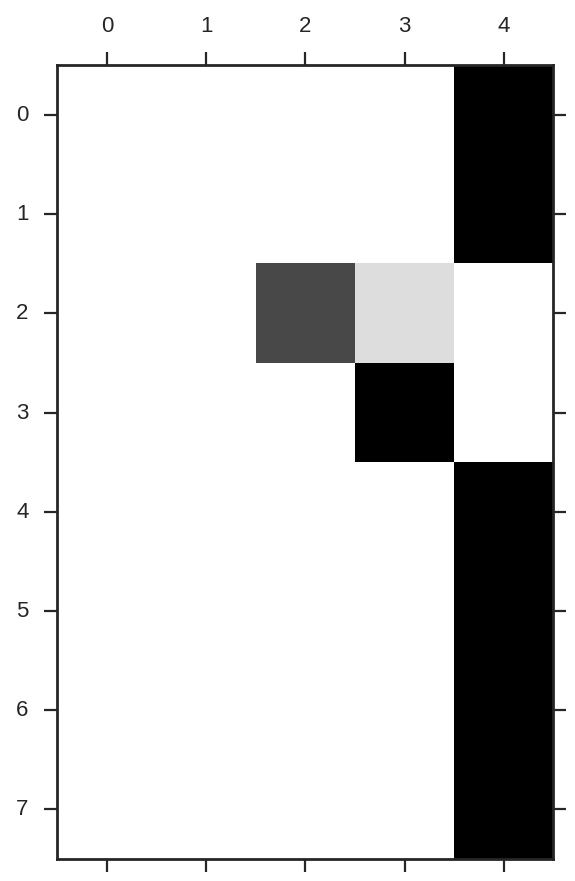

In [112]:
# mpl.style.use('default')
mpl.style.use('seaborn')
# mpl.style.use('classic')
# mpl.style.use('bmh')
mpl.style.use('seaborn-ticks')
%config InlineBackend.figure_format = 'retina'

output_words, attentions = evaluate("spiesze sie dzisiaj .")
fig=plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [ ]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = u mnie wszystko w porzadku .
output = i m very angry with in . . <EOS>


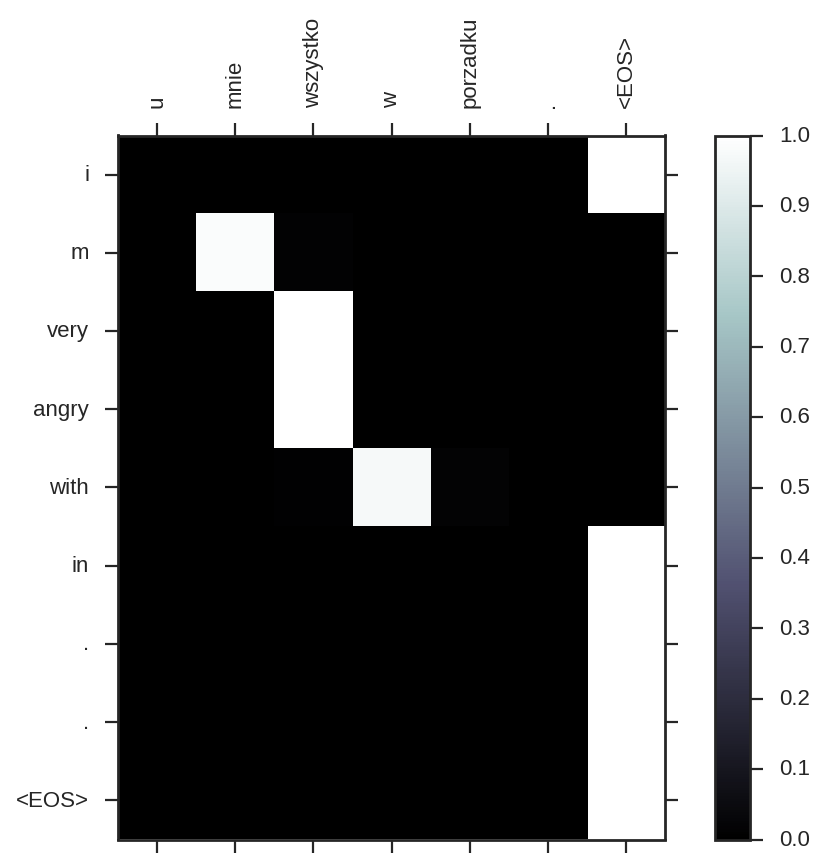

In [113]:
evaluate_and_show_attention("u mnie wszystko w porzadku .")

input = on tu jest !
output = he is here ! <EOS>


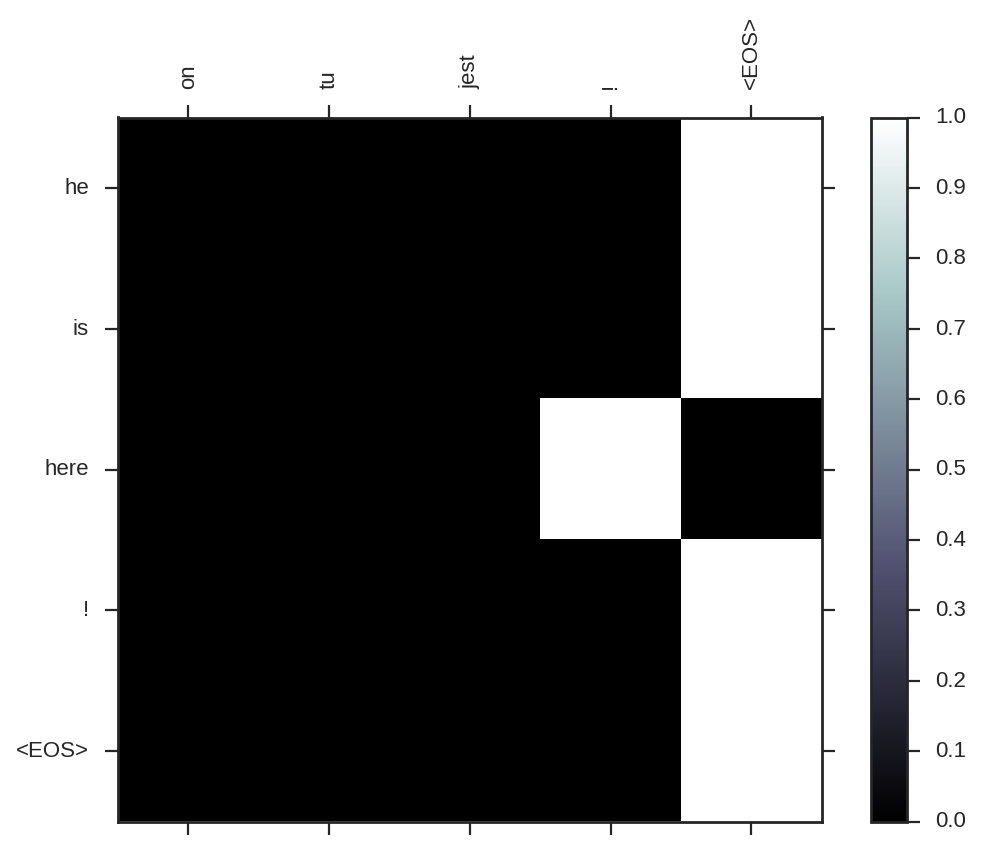

In [114]:
evaluate_and_show_attention("on tu jest !")

input = jestem nauczycielem japonskiego .
output = i m a japanese teacher . <EOS>


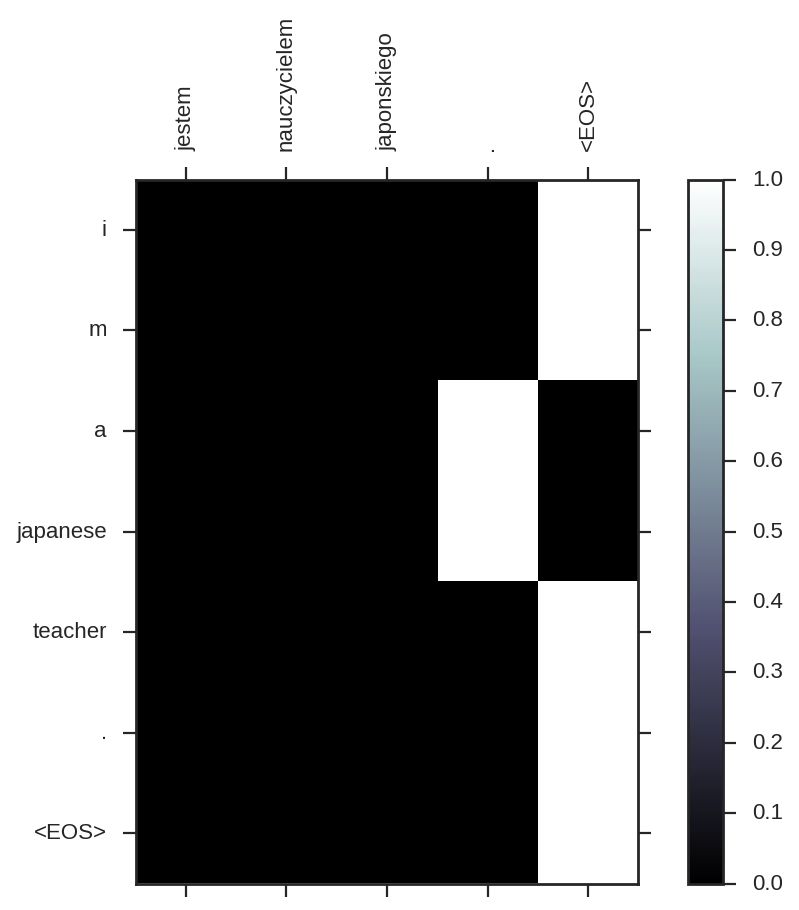

In [115]:
evaluate_and_show_attention("jestem nauczycielem japonskiego .")

input = ograniczam jedzenie s odyczy .
output = i m cutting down on sweets . <EOS>


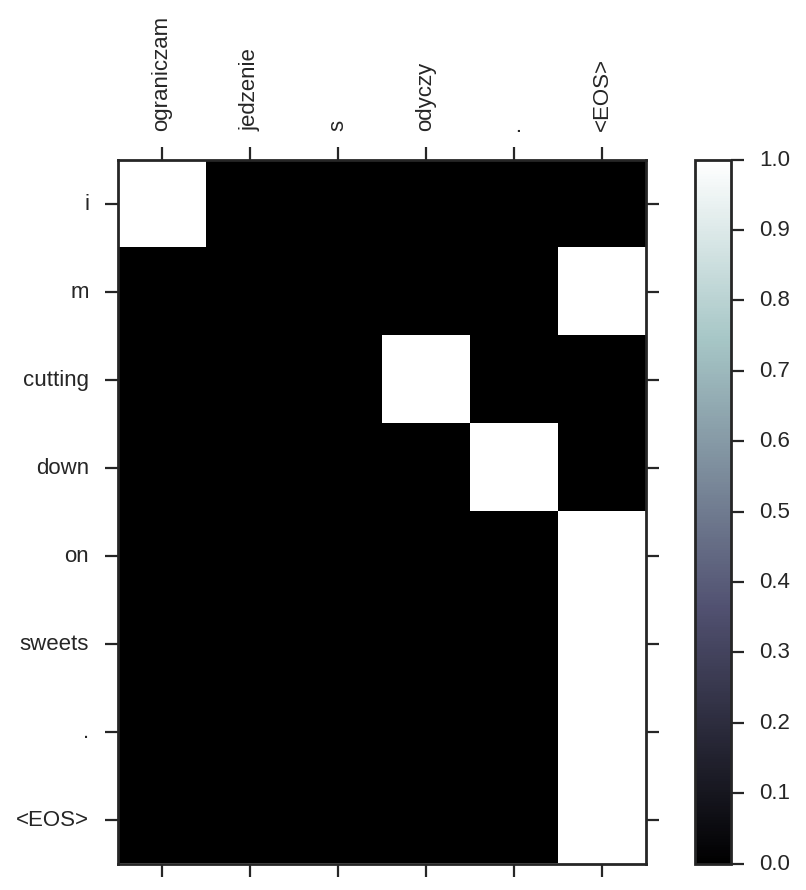

In [120]:
evaluate_and_show_attention("ograniczam jedzenie s odyczy .")

# Exercises

* Try with a different dataset
    * Another language pair
    * Human &rarr; Machine (e.g. IOT commands)
    * Chat &rarr; Response
    * Question &rarr; Answer
* Replace the embedding pre-trained word embeddings such as word2vec or GloVe
* Try with more layers, more hidden units, and more sentences. Compare the training time and results.
* If you use a translation file where pairs have two of the same phrase (`I am test \t I am test`), you can use this as an autoencoder. Try this:
    * Train as an autoencoder
    * Save only the Encoder network
    * Train a new Decoder for translation from there

In [121]:
!uptime

 19:18:45 up  7:22,  6 users,  load average: 0.05, 0.09, 0.18
